### VaR Comparison

##### Imports & Config

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings("ignore")

#### Fetching stock data

In [3]:
stock_df = pd.read_csv('data/stock_data.csv')

In [4]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc=True)
stock_df['Date'] = stock_df['Date'].dt.date
stock_df['Date'] = stock_df['Date'].apply(lambda x: dt.datetime.combine(x, dt.time(0, 0)))

In [5]:
def convert_csv_df_to_yf_df(csv_df):
    """Convert a CSV DataFrame to a format similar to Yahoo Finance DataFrame.
    The CSV DataFrame should have 'Date', 'Ticker', 'Open', 'High', 'Low', 'Close', and 'Volume' columns.
    """    

    # Ensure the Date column is of datetime type.
    csv_df['Date'] = pd.to_datetime(csv_df['Date'])

    # Define the price columns that you want to keep.
    price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Pivot the DataFrame.
    # With a list for values, pivot_table creates a MultiIndex on the columns where the first level is the price fields
    # and the second level is the ticker symbol.
    multi_df = csv_df.pivot_table(index='Date', columns='Ticker', values=price_cols)

    # Optionally, sort the MultiIndex columns.
    multi_df = multi_df.sort_index(axis=1)

    # Set the MultiIndex column names so that the first level is 'Price' and the second is 'Ticker'.
    multi_df.columns.names = ['Price', 'Ticker']

    return multi_df


#### Declaring classes

##### Portofolio Class

In [6]:

class PortofolioData:
    def __init__(self, stocks, weights, Time, initial_investment, forecast_start_date=dt.datetime.now(), yahoo_finance=False):
        self.stocks = stocks
        self.weights = np.array(weights)
        self.Time = Time  # number of days over which the var is calculated
        self.initial_investment = initial_investment
        self.forecast_start_date = forecast_start_date
        self.yahoo_finance = yahoo_finance
        self.returns, self.mean_returns, self.cov_matrix = self.get_data(
                start_date=forecast_start_date-dt.timedelta(days=800), end_date=forecast_start_date, yahoo_finance=yahoo_finance)

    def get_data(
        self,
        start_date=dt.datetime.now() - dt.timedelta(days=800),
        end_date=dt.datetime.now(),
        yahoo_finance=False,
    ):
        # Get historical data and calculate returns
        if yahoo_finance:
            stock_data = yf.download(self.stocks, start=start_date, end=end_date)
        else:
            stock_data = stock_df[(stock_df['Ticker'].isin(self.stocks)) & (stock_df['Date'] >= start_date) & (stock_df['Date'] <= end_date)]
            stock_data = convert_csv_df_to_yf_df(stock_data)
        stock_data = stock_data["Close"]
        returns = stock_data.pct_change()
        mean_returns = returns.mean()
        cov_matrix = returns.cov()
        returns = returns.dropna()
        returns["portofolio"] = returns.dot(self.weights)

        if stock_data.empty:
            raise ValueError("No data found for the selected date range and tickers.")


        return returns, mean_returns, cov_matrix

    def get_expected_portofolio_performance(self):
        expected_returns = np.sum(self.mean_returns * self.weights) * self.Time
        expected_std = np.sqrt(
            np.dot(self.weights.T, np.dot(self.cov_matrix, self.weights))
        ) * np.sqrt(self.Time)
        return expected_returns, expected_std

    def __str__(self):
        txt = ""
        txt += f"PORTOFOLIO: {self.initial_investment}\n"
        for i in range(len(self.stocks)):
            txt += f"{self.stocks[i]}:{self.weights[i]*100}%\n"
        txt += "--------------------------\n"
        txt += "Returns:\n"
        txt += f"{self.returns}\n"
        txt += "--------------------------\n"
        txt += "Mean Returns:\n"
        txt += f"{self.mean_returns}\n"
        txt += "--------------------------\n"
        txt += "Covariance Matrix\n"
        txt += f"{self.cov_matrix}\n"
        txt += "--------------------------\n"
        return txt


##### VaR Class

In [7]:
class VaR:
    def __init__(self, portofolio: PortofolioData, confidence_level=0.95):
        self.portofolio = portofolio
        self.confidence_level = confidence_level
        self.alpha = 1 - confidence_level

    def calculate_historical_var(self):
        h_var = -np.percentile(
            self.portofolio.returns["portofolio"], self.alpha * 100
        ) * np.sqrt(self.portofolio.Time)

        return {
            "relative": h_var,
            "absolute": self.portofolio.initial_investment * h_var,
        }

    def calculate_parametric_var(self):

        expected_portofolio_return, expected_portofolio_std = (
            self.portofolio.get_expected_portofolio_performance()
        )

        p_var = (
            norm.ppf(self.confidence_level) * expected_portofolio_std
            - expected_portofolio_return
        )

        return {
            "relative": p_var,
            "absolute": self.portofolio.initial_investment * p_var,
        }

    def calculate_monte_carlo_var(self, simulations=1000):
        mean_m = np.full(
            shape=(self.portofolio.Time, len(self.portofolio.weights)),
            fill_value=self.portofolio.mean_returns,
        )
        mean_m = mean_m.T

        portfolio_sims = np.full(
            shape=(self.portofolio.Time, simulations), fill_value=0.0
        )

        for m in range(0, simulations):
            Z = np.random.normal(
                size=(self.portofolio.Time, len(self.portofolio.weights))
            )
            L = np.linalg.cholesky(self.portofolio.cov_matrix)
            daily_returns = mean_m + np.inner(L, Z)
            portfolio_sims[:, m] = (
                np.cumprod(np.inner(self.portofolio.weights, daily_returns.T) + 1)
                * self.portofolio.initial_investment
            )

        portResults = pd.Series(portfolio_sims[-1, :])
        kept = np.percentile(portResults, self.alpha * 100)

        absolute_mc_var = self.portofolio.initial_investment - kept
        relative_mc_var = absolute_mc_var / self.portofolio.initial_investment

        return {
            "relative": relative_mc_var,
            "absolute": absolute_mc_var,
        }
    
    def calculate_all_vars(self, version='relative', multiplier=1):
        historical_var = self.calculate_historical_var()
        parametric_var = self.calculate_parametric_var()
        monte_carlo_var = self.calculate_monte_carlo_var()

       

        return {
            "historical": multiplier*historical_var[version],
            "parametric": multiplier*parametric_var[version],
            "monte_carlo": multiplier*monte_carlo_var[version],
        }

    def __str__(self):
        historical_var = self.calculate_historical_var()
        parametric_var = self.calculate_parametric_var()
        monte_carlo_var = self.calculate_monte_carlo_var()

        txt = "Value at Risk (VaR) Analysis:\n"
        txt += f"Confidence Level: {self.confidence_level * 100}%\n"
        txt += f"Historical VaR: {historical_var}\n"
        txt += f"Parametric VaR: {parametric_var}\n"
        txt += f"Monte Carlo VaR: {monte_carlo_var}\n"
        return txt

##### Fetching test portofolios

In [8]:
from generate_random_portfolios import read_portfolios_from_json

test_portfolios = read_portfolios_from_json("data/random_portfolios.json")

In [9]:
tp = test_portfolios[1]
stocks = tp["stocks_list"]
weights = tp["stocks_weights"]
initial_investment = tp['initial_investment']
end_date = dt.datetime.strptime(tp["start_date"], "%Y-%m-%d")
start_date = end_date - dt.timedelta(days=800)


stock_data = stock_df[(stock_df['Ticker'].isin(stocks)) & (stock_df['Date'] >= start_date) & (stock_df['Date'] <= end_date)]
stock_data = convert_csv_df_to_yf_df(stock_data)

In [10]:
stock_data.head()

Price           Close                                           High  \
Ticker            DAL         FDX          MA        SBUX        DAL   
Date                                                                   
2021-04-21  45.604214  267.308014  378.183594  110.944489  45.644131   
2021-04-22  44.556416  265.655701  378.440216  110.165192  46.232895   
2021-04-23  45.704002  266.808441  382.092712  111.723793  45.843708   
2021-04-26  46.512306  264.906403  382.497498  110.165192  47.001277   
2021-04-27  46.242870  276.193939  384.076935  110.383789  46.642033   

Price                                                 Low              \
Ticker             FDX          MA        SBUX        DAL         FDX   
Date                                                                    
2021-04-21  270.007413  379.170761  111.438677  43.249160  266.184051   
2021-04-22  270.007404  384.501434  111.077532  44.536457  265.501995   
2021-04-23  268.201382  384.876530  112.122948  44.356834  266.068758   
2021-04-26  268.854623  387.897301  111.429166  46.023332  263.407805   
2021-04-27  280.699348  385.419467  110.611872  45.993394  273.139078   

Price                                    Open                          \
Ticker              MA        SBUX        DAL         FDX          MA   
Date                                                                    
2021-04-21  371.836119  110.108178  43.907776  268.066899  373.731462   
2021-04-22  377.087802  109.509451  45.963460  266.414586  378.163811   
2021-04-23  378.538907  110.089180  44.716080  267.557740  379.417499   
2021-04-26  382.132251  109.347885  46.402536  268.316667  382.852863   
2021-04-27  381.184544  109.547472  46.562199  275.281318  383.237837   

Price                       Volume                                   
Ticker            SBUX         DAL        FDX         MA       SBUX  
Date                                                                 
2021-04-21  110.326756  16267100.0  1861400.0  2466300.0  4397400.0  
2021-04-22  111.068034  17303200.0  1444800.0  3713700.0  5744900.0  
2021-04-23  110.260245   9162700.0  1312800.0  2294800.0  4555800.0  
2021-04-26  111.144057  11260000.0  1747000.0  2255000.0  5924900.0  
2021-04-27  109.927615   8151600.0  4961900.0  2270000.0  7260900.0

#### Comparing the VaR methods

##### Getting daily returns

In [11]:
# Get returns for each portofolio
returns = []
portofolios = []

for test_portfolio in test_portfolios:

    test_portfolio["start_date"] = dt.datetime.strptime(test_portfolio["start_date"], "%Y-%m-%d")

    portofolio = PortofolioData(
        stocks=test_portfolio["stocks_list"],
        weights=test_portfolio["stocks_weights"],
        Time=test_portfolio["time"],
        initial_investment=test_portfolio["initial_investment"],
        forecast_start_date=  test_portfolio["start_date"],
        yahoo_finance=False,
    )
    portofolios.append(portofolio)
    

    ret, mean_ret, cov_matrix = portofolio.get_data(
        test_portfolio["start_date"], 
        test_portfolio["start_date"] + dt.timedelta(days=test_portfolio["time"])
    )

    returns.append(ret)


In [12]:

def show_portfolio_distribution(returns, quantile = 0.05):
    sns.histplot(returns, bins=30, kde=True)

    quantile_mark = returns.quantile(quantile)  
    plt.axvline(quantile_mark, color='red', linestyle='dashed', label=f'95% Quantile: {quantile_mark:.4f}')

    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution')
    plt.legend()
    plt.show()

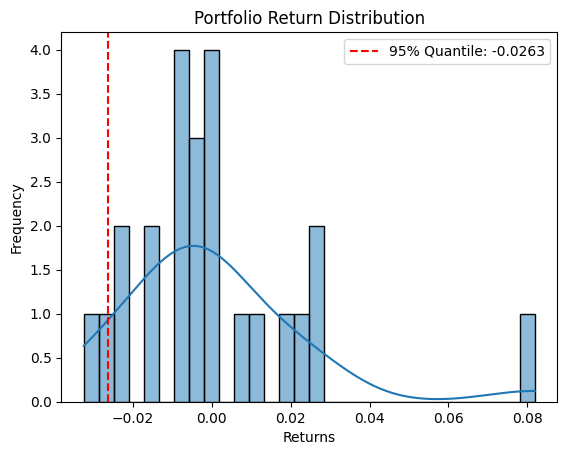

In [13]:
show_portfolio_distribution(returns[2]['portofolio'])

In [14]:
def compare_portfolio_distributions(forecast_returns, historic_returns, label1="Returns to Forecast", label2="Past historical Returns", quantile=0.05):
    plt.figure(figsize=(10, 6))
    
    # Plot both distributions
    sns.histplot(forecast_returns, bins=30, kde=True, color='blue', label=label1, stat="density", alpha=0.6)
    sns.histplot(historic_returns, bins=30, kde=True, color='orange', label=label2, stat="density", alpha=0.6)

    # Calculate quantiles
    q1 = forecast_returns.quantile(quantile)
    q2 = historic_returns.quantile(quantile)

    # Add vertical lines at quantiles
    plt.axvline(q1, color='blue', linestyle='dashed', label=f'{label1} {int(quantile*100)}% Quantile: {q1:.4f}')
    plt.axvline(q2, color='orange', linestyle='dashed', label=f'{label2} {int(quantile*100)}% Quantile: {q2:.4f}')
    
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.title('Comparison of Portfolio Return Distributions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

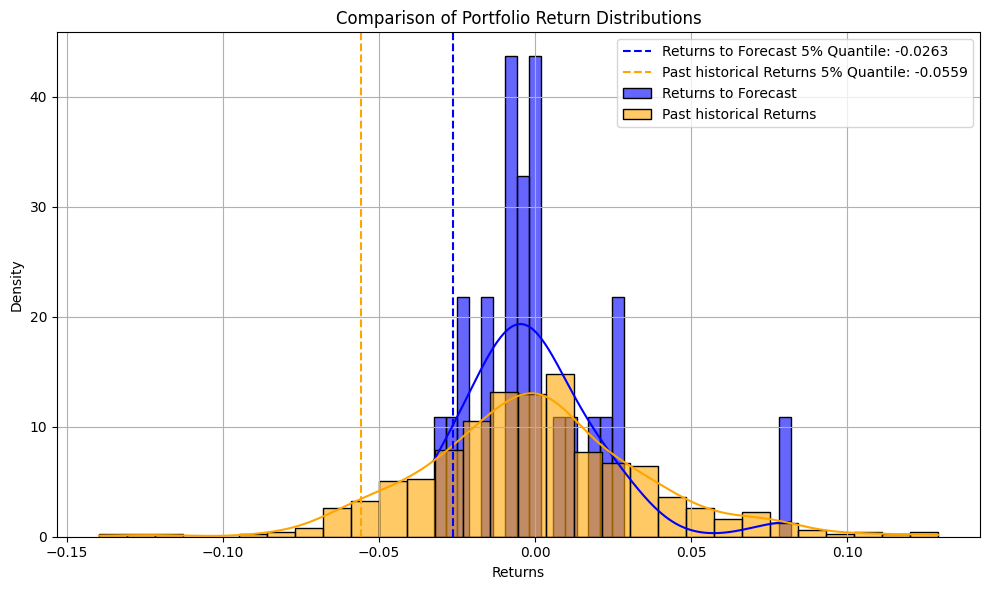

In [15]:
index = 2

compare_portfolio_distributions(returns[2]['portofolio'],portofolios[index].returns['portofolio'])

In [16]:
values_at_risk = []
for portofolio in portofolios:
    try:
        var = VaR(portofolio, confidence_level=0.95)

        values_at_risk.append(
            {
                "historical": -var.calculate_historical_var()['relative'],
                "parametric": -var.calculate_parametric_var()['relative'],
                "monte_carlo": -var.calculate_monte_carlo_var()['relative'],
            }
        )
    except:
        print('VaR could not be calculated')

In [17]:


def show_portfolio_distribution_with_vars(returns, var_dict, time_horizon=1, quantile=0.05, ):
    # Plot the distribution with histogram and KDE
    returns = returns * np.sqrt(time_horizon)  # Scale returns for the time horizon
    sns.histplot(returns, bins=50, kde=True)
    
    # Plot the base quantile (for reference)
    base_quantile = returns.quantile(quantile)
    plt.axvline(base_quantile, color='black', 
                label=f'{quantile*100:.0f}% Quantile of Returns: {base_quantile:.4f}')
    
    # Define a unique color for each VaR method
    colors = {
        "historical": "red",
        "parametric": "blue",
        "monte_carlo": "green"
    }
    
    # Plot a vertical line for each VaR method
    for method, var_value in var_dict.items():
        plt.axvline(var_value, color=colors.get(method, "gray"), linestyle='dashed', 
                    label=f'{method.capitalize()} VaR: {var_value:.4f}')
    
    # Determine the range to zoom in on the vertical lines
    # Get minimum and maximum of base quantile and all VaR values
    values = [base_quantile] + list(var_dict.values())
    min_val, max_val = min(values), max(values)
    
    # Calculate margin: you can adjust this multiplier to zoom in/out as desired
    margin = (max_val - min_val) * 0.5  
    plt.xlim(min_val - margin, max_val + margin)
    
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution with VaR Estimates')
    plt.legend()
    plt.show()



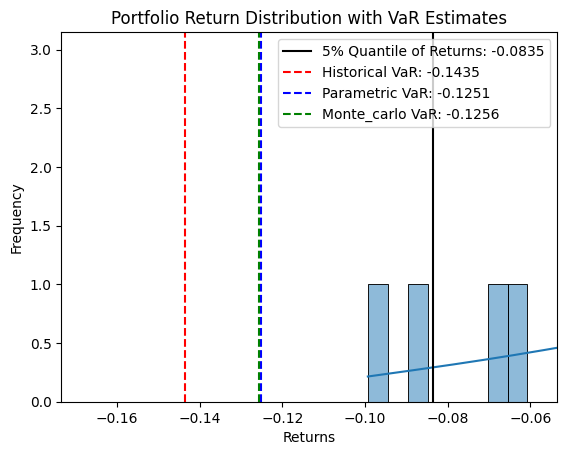

In [18]:
min_index = 4
show_portfolio_distribution_with_vars(returns[min_index]['portofolio'][:], values_at_risk[min_index], time_horizon=portofolios[min_index].Time, quantile=0.05)

##### RMSE

For our chosen way of comparing the models, we will pick the root square mean deviation (RMSE).

In [19]:
def root_mean_squared_error(prediction, truth):
    return np.sqrt(np.mean((prediction - truth) ** 2))

In [20]:
rmses = []

for i in range(len(values_at_risk)):
    truth = returns[i]['portofolio'].quantile(0.95)
    historical_var = values_at_risk[i]['historical']
    parametric_var = values_at_risk[i]['parametric']
    monte_carlo_var = values_at_risk[i]['monte_carlo']

    rmses.append(
        {
            "historical": root_mean_squared_error(historical_var, truth),
            "parametric": root_mean_squared_error(parametric_var, truth),
            "monte_carlo": root_mean_squared_error(monte_carlo_var, truth),
        }
    )

In [21]:
returns[0]['portofolio'].quantile(0.05)

np.float64(-0.03250959649179564)

In [22]:
values_at_risk[0]['historical']

np.float64(-0.0503145841453682)

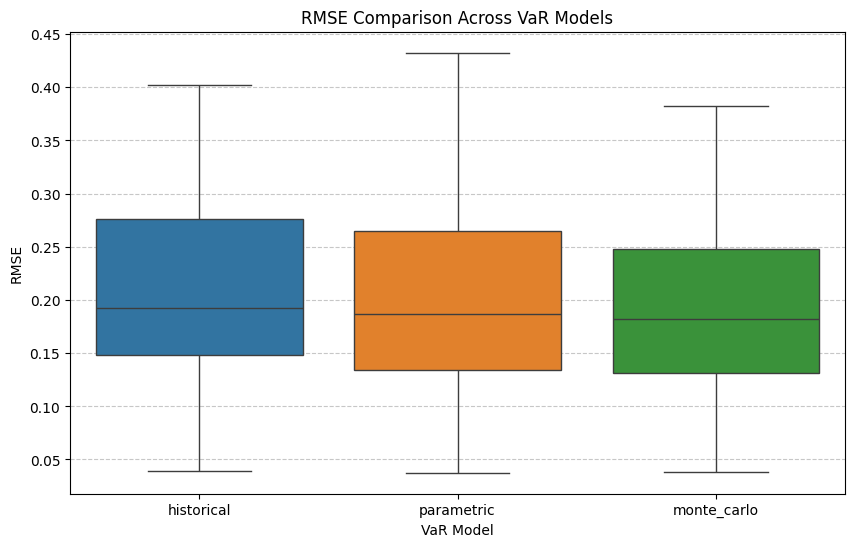

In [23]:
rmse_df = pd.DataFrame(rmses)

# Plot the RMSE values
plt.figure(figsize=(10, 6))
sns.boxplot(data=rmse_df)

plt.title("RMSE Comparison Across VaR Models")
plt.ylabel("RMSE")
plt.xlabel("VaR Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [24]:
len(rmse_df)

100

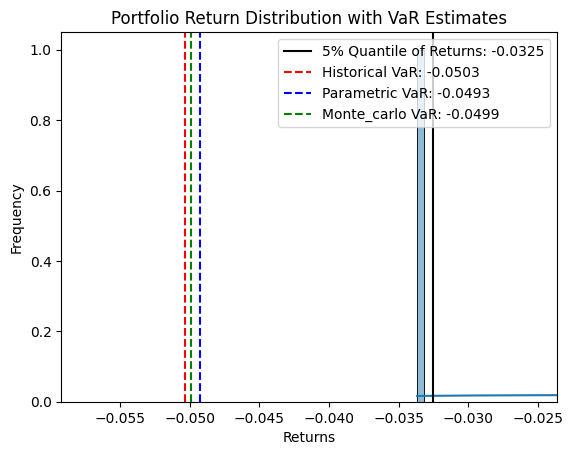

In [25]:
min_index = rmse_df['historical'].idxmin()
show_portfolio_distribution_with_vars(returns[min_index]['portofolio'], values_at_risk[min_index], quantile=0.05)

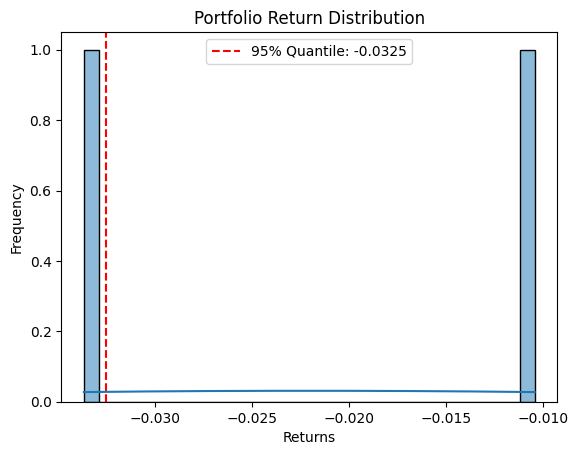

In [26]:
show_portfolio_distribution(returns[min_index]['portofolio'], quantile=0.05)

In [27]:
test_portfolios[min_index]

{'stocks_list': ['MSFT', 'NTDOY', 'SPOT', 'ADBE', 'TGT', 'PHG'],
 'stocks_weights': [0.208, 0.231, 0.065, 0.088, 0.139, 0.269],
 'initial_investment': 36197.15,
 'time': 3,
 'start_date': datetime.datetime(2023, 9, 20, 0, 0)}

In [28]:
rmse_df.describe()

,historical,parametric,monte_carlo
count,100.000000,100.000000,100.000000
mean,0.209977,0.199947,0.190001
std,0.085266,0.085349,0.076006
min,0.038729,0.037666,0.038341
25%,0.147856,0.133767,0.131461
50%,0.192119,0.186872,0.182330
75%,0.275848,0.264988,0.248124
max,0.401931,0.432517,0.381880


##### RMSE v2

In [29]:
worst_losses = []
values_at_risk = {
    0.99:[],
    0.95:[],
    0.90:[],
    0.85:[],
    0.8:[],
    0.75:[],
    0.7:[],

}

for portofolio in portofolios[:]:
    forecast_start_date = portofolio.forecast_start_date
    returns_array, _, _ = portofolio.get_data(start_date=forecast_start_date - dt.timedelta(days=1),
                                               end_date=forecast_start_date + dt.timedelta(days=(portofolio.Time + 1)),
                                               yahoo_finance=False)

    returns_array = returns_array['portofolio']
    # print(returns_array)

    # 1. Start with an initial value of +0% (Day 0)
    cumulative_returns = (1 + returns_array).cumprod() - 1

    # 2. Calculate the maximum cumulative return up to each point in time
    max_cumulative_returns = cumulative_returns.cummax()

    # 3. Calculate the drawdown (difference from the peak at each point in time)
    drawdowns = cumulative_returns - max_cumulative_returns

    # 4. Find the worst loss (maximum drawdown)
    worst_loss = drawdowns.min()
    worst_losses.append(worst_loss)
    for conf_level in values_at_risk.keys():
        var_obj = VaR(portofolio, confidence_level=conf_level)
        values_at_risk[conf_level].append(var_obj.calculate_all_vars('relative',-1))




In [30]:
for conf_level in values_at_risk.keys():
    new_dict = {
        'historical':[],
        'parametric':[],
        'monte_carlo':[],
    }
    for element in values_at_risk[conf_level]:
        for method in element.keys():
            new_dict[method].append(element[method])
    values_at_risk[conf_level] = new_dict

In [31]:
flattened_dict = {}

for confidence_level, methods in values_at_risk.items():
    for method, values in methods.items():
        key = f"{confidence_level}_{method}"  # Create new key like '90_historical'
        flattened_dict[key] = values

values_at_risk = flattened_dict

In [32]:
rmse_dict = {}

for key, predictions in flattened_dict.items():
    # Extract the confidence level from the key to match with the worst_losses (assuming they are aligned)
    rmse_dict[key] = root_mean_squared_error(np.array(predictions), np.array(worst_losses))

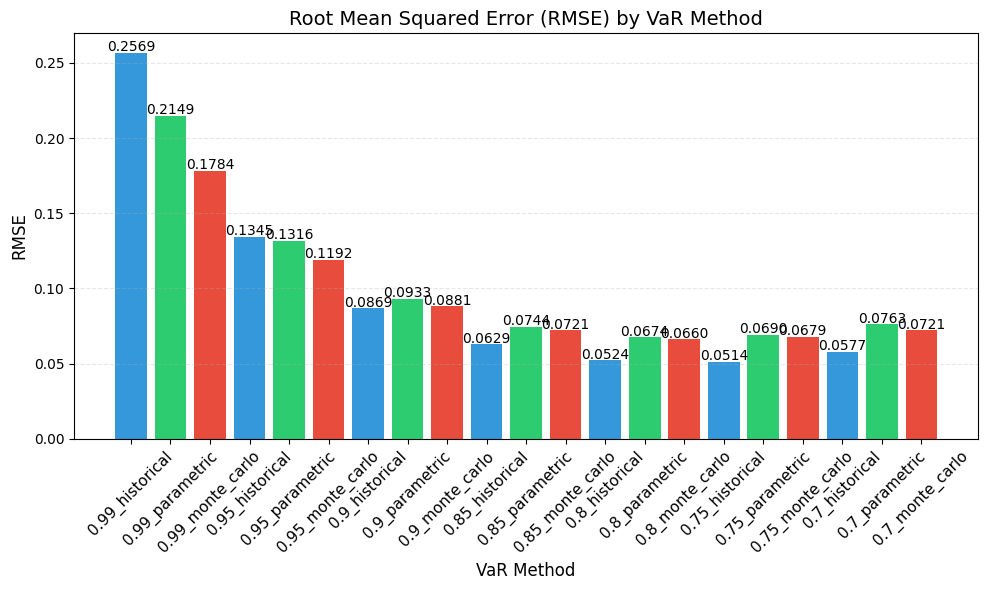

In [33]:
# Extract values and labels from rmse_dict
methods = list(rmse_dict.keys())
rmse_values = list(rmse_dict.values())

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, rmse_values, color=['#3498db', '#2ecc71', '#e74c3c'] * (len(methods) // 3 + 1))

# Add value labels on top of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{rmse_values[i]:.4f}', ha='center', fontsize=10)

# Add title and labels
plt.title('Root Mean Squared Error (RMSE) by VaR Method', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('VaR Method', fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Rotate x-axis labels
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()


##### Backtesting

In [34]:
# def backtest_all_var_methods(portofolio: PortofolioData, confidence_level=0.95):
#     start_date = pd.to_datetime("2023-07-01")
#     end_date = pd.to_datetime("2024-12-01")

#     backtesting_portofolio = PortofolioData(
#         portofolio.stocks, 
#         portofolio.weights, 
#         portofolio.Time, 
#         portofolio.initial_investment
#     )

#     returns, _, _ = backtesting_portofolio.get_data(start_date, end_date, False)
#     returns = returns['portofolio']
#     window = portofolio.Time

#     results = {
#         'historical': {'violations': [], 'predictions': [], 'actuals': [], 'indices': []},
#         'parametric': {'violations': [], 'predictions': [], 'actuals': [], 'indices': []},
#         'monte_carlo': {'violations': [], 'predictions': [], 'actuals': [], 'indices': []}
#     }

#     for i in range(len(returns) - window + 1):
#         window_returns = returns.iloc[i:i+window]

#         sub_portfolio = PortofolioData(
#             portofolio.stocks, 
#             portofolio.weights, 
#             window, 
#             portofolio.initial_investment,
#             forecast_start_date=window_returns.index[-1]
#         )

#         var_obj = prediction(sub_portfolio, confidence_level)

#         hist_dict  = var_obj.calculate_historical_var()
#         param_dict = var_obj.calculate_parametric_var()
#         mc_dict    = var_obj.calculate_monte_carlo_var()

#         actual_loss = window_returns.sum()
#         current_date = window_returns.index[-1]

#         # Store values and check for violations
#         for method, var_dict in zip(['historical', 'parametric', 'monte_carlo'], 
#                                     [hist_dict, param_dict, mc_dict]):
#             pred = var_dict['relative']
#             results[method]['predictions'].append(pred)
#             results[method]['actuals'].append(actual_loss)
#             results[method]['violations'].append(1 if actual_loss < -pred else 0)
#             results[method]['indices'].append(current_date)

#     # Compute violation_pct and RMSE for each method
#     for method in results:
#         violations = results[method]['violations']
#         predictions = np.array(results[method]['predictions'])
#         actuals = np.array(results[method]['actuals'])

#         # Compute violation percentage
#         violation_pct = np.mean(violations) * 100 
#         results[method]['violation_pct'] = violation_pct

#         # Compute RMSE
#         rmse = root_mean_squared_error(-predictions, actuals)  # negate actuals to match VaR convention
#         results[method]['rmse'] = rmse

#     return results

In [35]:
# results_dict = {
#     'historical': [],
#     'parametric': [],
#     'monte_carlo': []
# }


# rmse_dict = {
#     'historical': [],
#     'parametric': [],
#     'monte_carlo': []
# }

# cnt = 0
# for portofolio in portofolios[:]:
#     cnt+=1
#     print(f'{cnt} done')
#     backtest_results = backtest_all_var_methods(portofolio, confidence_level=0.95)
#     # Each backtest_results is a dictionary with keys 'historical', 'parametric', 'monte_carlo'
#     results_dict['historical'].append(backtest_results['historical']['violation_pct'])
#     results_dict['parametric'].append(backtest_results['parametric']['violation_pct'])
#     results_dict['monte_carlo'].append(backtest_results['monte_carlo']['violation_pct'])

#     rmse_dict['historical'].append(backtest_results['historical']['rmse'])
#     rmse_dict['parametric'].append(backtest_results['parametric']['rmse'])
#     rmse_dict['monte_carlo'].append(backtest_results['monte_carlo']['rmse'])

In [36]:
# df = pd.DataFrame(results_dict)
# df_long = df.melt(var_name='Method', value_name='Violation %')

# # Plotting
# plt.figure(figsize=(8, 6))
# sns.boxplot(data=df_long, x='Method', y='Violation %', palette='Set2')
# plt.title('VaR Backtest Violation Percentage by Method')
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

In [37]:
# plt.figure(figsize=(10, 6))
# plt.boxplot(
#     [rmse_dict['historical'], rmse_dict['parametric'], rmse_dict['monte_carlo']],
#     labels=['Historical', 'Parametric', 'Monte Carlo']
# )
# plt.title('RMSE of 95% VaR')
# plt.ylabel('RMSE')
# plt.grid(True)
# plt.show()


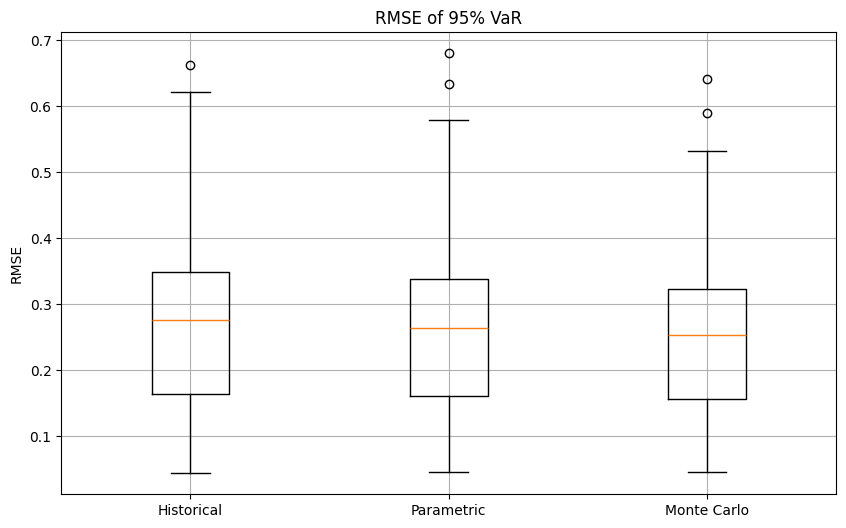

In [38]:
# results_dict = {
#     'historical': [],
#     'parametric': [],
#     'monte_carlo': []
# }


# rmse_dict = {
#     'historical': [],
#     'parametric': [],
#     'monte_carlo': []
# }

# cnt = 0
# for portofolio in portofolios[:]:
#     cnt+=1
#     print(f'{cnt} done')
#     backtest_results = backtest_all_var_methods(portofolio, confidence_level=0.99)
#     # Each backtest_results is a dictionary with keys 'historical', 'parametric', 'monte_carlo'
#     results_dict['historical'].append(backtest_results['historical']['violation_pct'])
#     results_dict['parametric'].append(backtest_results['parametric']['violation_pct'])
#     results_dict['monte_carlo'].append(backtest_results['monte_carlo']['violation_pct'])

#     rmse_dict['historical'].append(backtest_results['historical']['rmse'])
#     rmse_dict['parametric'].append(backtest_results['parametric']['rmse'])
#     rmse_dict['monte_carlo'].append(backtest_results['monte_carlo']['rmse'])

In [39]:
# df = pd.DataFrame(results_dict)
# df_long = df.melt(var_name='Method', value_name='Violation %')

# # Plotting
# plt.figure(figsize=(8, 6))
# sns.boxplot(data=df_long, x='Method', y='Violation %', palette='Set2')
# plt.title('VaR Backtest Violation Percentage by Method')
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

In [40]:
# plt.figure(figsize=(10, 6))
# plt.boxplot(
#     [rmse_dict['historical'], rmse_dict['parametric'], rmse_dict['monte_carlo']],
#     labels=['Historical', 'Parametric', 'Monte Carlo']
# )
# plt.title('RMSE of 99% VaR')
# plt.ylabel('RMSE')
# plt.grid(True)
# plt.show()


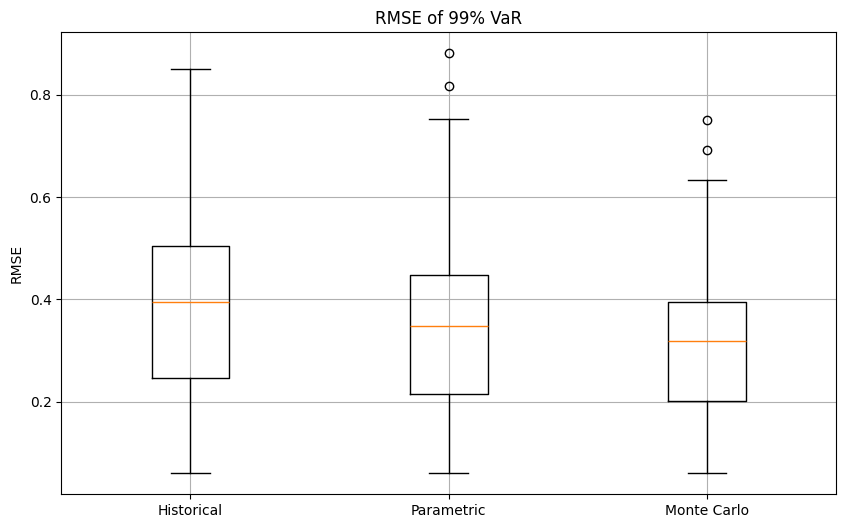

In [41]:
# for method in rmse_dict.keys():
#     for i in range(len(rmse_dict[method])):
#         if rmse_dict[method][i]:
#             print(f'{method} has {rmse_dict[method][i]} at index {i}')


We can notice that the 95% VaR model is closer to the truth value. This occurs due to the fact that the 99% VaR tends to exagerate the risks. It does have less violations, but the predicted value is further away from the actual losses.

### Custom VaR Model

#### We will try a ARIMA model based on the rolling returns

In [42]:
from statsmodels.tsa.arima.model import ARIMA